In [1]:
!pip install super-gradients
!pip install --upgrade pillow
!pip install --upgrade torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 42.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 38.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 71.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 84.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 78.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) 

In [2]:
import os
import random
import torch
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

import warnings

[2023-09-20 18:55:25] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-09-20 18:55:25] WARNING - __init__.py - Failed to import pytorch_quantization
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[2023-09-20 18:55:37] INFO - utils.py - NumExpr defaulting to 2 threads.
/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-09-20 18:55:42] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-09-20 18:55:42] WARNING - export.py - Failed to import pytorch_quantization
[2023-09-20 18:55:42] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-09-20 18:55:42] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-09-20 18:55:42] WA

In [3]:
class Config:
    CHECKPOINT_DIR = 'checkpoints'
    EXPERIMENT_NAME = 'finding-battleships'
    DATA_DIR = '/kaggle/input/traffic-detection-project'
    TRAIN_IMAGES_DIR = 'train/images'
    TRAIN_LABELS_DIR = 'train/labels'
    VAL_IMAGES_DIR = 'valid/images'
    VAL_LABELS_DIR = 'valid/labels'
    TEST_IMAGES_DIR = 'test/images'
    TEST_LABELS_DIR = 'test/labels'
    CLASSES = ['bicycle', 'bus', 'car', 'motorbike', 'person']
    NUM_CLASSES = len(CLASSES)
    DATALOADER_PARAMS = {
        'batch_size': 16,
        'num_workers': 2
    }
    MODEL_NAME = 'yolo_nas_l'
    PRETRAINED_WEIGHTS = 'coco'

[2023-09-20 18:55:43] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 5805/5805 [01:20<00:00, 71.98it/s]
[2023-09-20 18:57:04] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 549/549 [00:05<00:00, 108.05it/s]
[2023-09-20 18:57:10] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 279/279 [00:02<00:00, 112.33it/s]


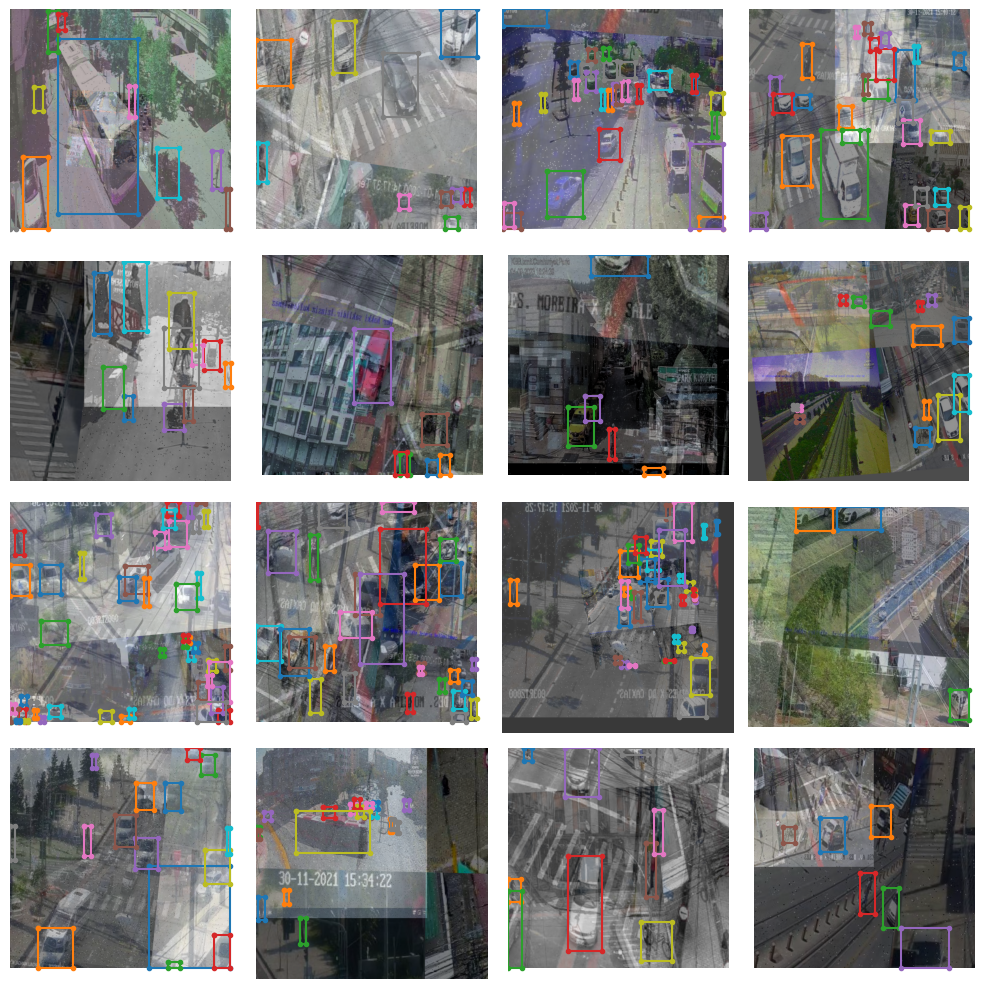

In [4]:
# Initialize Trainer
trainer = Trainer(experiment_name=Config.EXPERIMENT_NAME,
                  ckpt_root_dir=Config.CHECKPOINT_DIR)

Config.DATALOADER_PARAMS['batch_size'] = 8  # Reduce batch size to 8


# Load Data with the updated batch size
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': Config.DATA_DIR,
        'images_dir': Config.TRAIN_IMAGES_DIR,
        'labels_dir': Config.TRAIN_LABELS_DIR,
        'classes': Config.CLASSES
    },
    dataloader_params=Config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': Config.DATA_DIR,
        'images_dir': Config.VAL_IMAGES_DIR,
        'labels_dir': Config.VAL_LABELS_DIR,
        'classes': Config.CLASSES
    },
    dataloader_params=Config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': Config.DATA_DIR,
        'images_dir': Config.TEST_IMAGES_DIR,
        'labels_dir': Config.TEST_LABELS_DIR,
        'classes': Config.CLASSES
    },
    dataloader_params=Config.DATALOADER_PARAMS
)

# Check train data (visualization)
train_data.dataset.plot()

In [5]:
# Load Model (on single GPU)
model = models.get(Config.MODEL_NAME,
                   num_classes=Config.NUM_CLASSES,
                   pretrained_weights=Config.PRETRAINED_WEIGHTS
                   )
model.to('cuda')

[2023-09-20 18:57:17] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:08<00:00, 31.8MB/s] 
[2023-09-20 18:57:26] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


YoloNAS_L(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr

In [8]:
# Training Parameters
train_params = {
    "average_best_models": True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=Config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=Config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

[2023-09-20 20:34:17] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [7]:
# Train the model on single GPU with reduced batch size
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to checkpoints/finding-battleships/console_Sep20_18_57_30.txt


[2023-09-20 18:57:41] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-09-20 18:57:44] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (2 available on the machine)
    - Dataset size:                 5712       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         714        (len(train_loader))
    - Gradient updates per epoch:   714        (len(train_loader) / batch_accumulate)

[2023-09-20 18:57:44] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Validating: 100%|██████████| 67/67 [00:27<00:00,  2.40it/s]
[2023-09-20 19:07:14] INFO - base_sg_logger.py -

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.8134
│   ├── Ppyoloeloss/loss_iou = 0.3198
│   ├── Ppyoloeloss/loss_dfl = 1.292
│   └── Ppyoloeloss/loss = 3.259
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3662
    ├── Ppyoloeloss/loss_iou = 0.2198
    ├── Ppyoloeloss/loss_dfl = 0.8867
    ├── Ppyoloeloss/loss = 2.359
    ├── Precision@0.50 = 0.036
    ├── Recall@0.50 = 0.1624
    ├── Map@0.50 = 0.128
    └── F1@0.50 = 0.0313



Validating epoch 1: 100%|██████████| 67/67 [00:28<00:00,  2.37it/s]
[2023-09-20 19:16:39] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-20 19:16:39] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7183138132095337


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8984
│   │   ├── Epoch N-1      = 1.8134 (↘ -0.915)
│   │   └── Best until now = 1.8134 (↘ -0.915)
│   ├── Ppyoloeloss/loss_iou = 0.2244
│   │   ├── Epoch N-1      = 0.3198 (↘ -0.0954)
│   │   └── Best until now = 0.3198 (↘ -0.0954)
│   ├── Ppyoloeloss/loss_dfl = 0.9107
│   │   ├── Epoch N-1      = 1.292  (↘ -0.3813)
│   │   └── Best until now = 1.292  (↘ -0.3813)
│   └── Ppyoloeloss/loss = 1.9148
│       ├── Epoch N-1      = 3.259  (↘ -1.3442)
│       └── Best until now = 3.259  (↘ -1.3442)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7561
    │   ├── Epoch N-1      = 1.3662 (↘ -0.6101)
    │   └── Best until now = 1.3662 (↘ -0.6101)
    ├── Ppyoloeloss/loss_iou = 0.167
    │   ├── Epoch N-1      = 0.2198 (↘ -0.0528)
    │   └── Best until now = 0.2198 (↘ -0.0528)
    ├── Ppyoloeloss/loss_dfl = 0.7512
    │   ├── Epoch N-1      = 0.8867 (↘ -0.1355)
    │   └── Best until now = 0.8867 (↘ -0.1355)
    ├── Ppyoloeloss/loss 

Validating epoch 2: 100%|██████████| 67/67 [00:28<00:00,  2.38it/s]
[2023-09-20 19:26:01] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-20 19:26:01] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7185393571853638


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8431
│   │   ├── Epoch N-1      = 0.8984 (↘ -0.0553)
│   │   └── Best until now = 0.8984 (↘ -0.0553)
│   ├── Ppyoloeloss/loss_iou = 0.2131
│   │   ├── Epoch N-1      = 0.2244 (↘ -0.0113)
│   │   └── Best until now = 0.2244 (↘ -0.0113)
│   ├── Ppyoloeloss/loss_dfl = 0.8868
│   │   ├── Epoch N-1      = 0.9107 (↘ -0.0239)
│   │   └── Best until now = 0.9107 (↘ -0.0239)
│   └── Ppyoloeloss/loss = 1.8193
│       ├── Epoch N-1      = 1.9148 (↘ -0.0955)
│       └── Best until now = 1.9148 (↘ -0.0955)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8221
    │   ├── Epoch N-1      = 0.7561 (↗ 0.0661)
    │   └── Best until now = 0.7561 (↗ 0.0661)
    ├── Ppyoloeloss/loss_iou = 0.1688
    │   ├── Epoch N-1      = 0.167  (↗ 0.0018)
    │   └── Best until now = 0.167  (↗ 0.0018)
    ├── Ppyoloeloss/loss_dfl = 0.7646
    │   ├── Epoch N-1      = 0.7512 (↗ 0.0135)
    │   └── Best until now = 0.7512 (↗ 0.0135)
    ├── Ppyoloeloss/loss = 1

Validating epoch 3: 100%|██████████| 67/67 [00:28<00:00,  2.39it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8345
│   │   ├── Epoch N-1      = 0.8431 (↘ -0.0086)
│   │   └── Best until now = 0.8431 (↘ -0.0086)
│   ├── Ppyoloeloss/loss_iou = 0.2131
│   │   ├── Epoch N-1      = 0.2131 (↘ -0.0)
│   │   └── Best until now = 0.2131 (↘ -0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.8854
│   │   ├── Epoch N-1      = 0.8868 (↘ -0.0014)
│   │   └── Best until now = 0.8868 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.8099
│       ├── Epoch N-1      = 1.8193 (↘ -0.0093)
│       └── Best until now = 1.8193 (↘ -0.0093)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7917
    │   ├── Epoch N-1      = 0.8221 (↘ -0.0304)
    │   └── Best until now = 0.7561 (↗ 0.0356)
    ├── Ppyoloeloss/loss_iou = 0.1789
    │   ├── Epoch N-1      = 0.1688 (↗ 0.0101)
    │   └── Best until now = 0.167  (↗ 0.0119)
    ├── Ppyoloeloss/loss_dfl = 0.7855
    │   ├── Epoch N-1      = 0.7646 (↗ 0.0208)
    │   └── Best until now = 0.7512 (↗ 0.0343)
    ├── Ppyoloeloss/loss = 1.6318

Validating epoch 4: 100%|██████████| 67/67 [00:27<00:00,  2.40it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8141
│   │   ├── Epoch N-1      = 0.8345 (↘ -0.0204)
│   │   └── Best until now = 0.8345 (↘ -0.0204)
│   ├── Ppyoloeloss/loss_iou = 0.207
│   │   ├── Epoch N-1      = 0.2131 (↘ -0.006)
│   │   └── Best until now = 0.2131 (↘ -0.006)
│   ├── Ppyoloeloss/loss_dfl = 0.8688
│   │   ├── Epoch N-1      = 0.8854 (↘ -0.0166)
│   │   └── Best until now = 0.8854 (↘ -0.0166)
│   └── Ppyoloeloss/loss = 1.7661
│       ├── Epoch N-1      = 1.8099 (↘ -0.0438)
│       └── Best until now = 1.8099 (↘ -0.0438)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7712
    │   ├── Epoch N-1      = 0.7917 (↘ -0.0205)
    │   └── Best until now = 0.7561 (↗ 0.0151)
    ├── Ppyoloeloss/loss_iou = 0.1676
    │   ├── Epoch N-1      = 0.1789 (↘ -0.0114)
    │   └── Best until now = 0.167  (↗ 0.0006)
    ├── Ppyoloeloss/loss_dfl = 0.7711
    │   ├── Epoch N-1      = 0.7855 (↘ -0.0144)
    │   └── Best until now = 0.7512 (↗ 0.0199)
    ├── Ppyoloeloss/loss = 1

Validating epoch 5: 100%|██████████| 67/67 [00:28<00:00,  2.38it/s]
[2023-09-20 19:54:33] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-20 19:54:33] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7750581502914429


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7992
│   │   ├── Epoch N-1      = 0.8141 (↘ -0.0149)
│   │   └── Best until now = 0.8141 (↘ -0.0149)
│   ├── Ppyoloeloss/loss_iou = 0.2011
│   │   ├── Epoch N-1      = 0.207  (↘ -0.0059)
│   │   └── Best until now = 0.207  (↘ -0.0059)
│   ├── Ppyoloeloss/loss_dfl = 0.8514
│   │   ├── Epoch N-1      = 0.8688 (↘ -0.0174)
│   │   └── Best until now = 0.8688 (↘ -0.0174)
│   └── Ppyoloeloss/loss = 1.7278
│       ├── Epoch N-1      = 1.7661 (↘ -0.0383)
│       └── Best until now = 1.7661 (↘ -0.0383)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7139
    │   ├── Epoch N-1      = 0.7712 (↘ -0.0573)
    │   └── Best until now = 0.7561 (↘ -0.0421)
    ├── Ppyoloeloss/loss_iou = 0.1624
    │   ├── Epoch N-1      = 0.1676 (↘ -0.0051)
    │   └── Best until now = 0.167  (↘ -0.0046)
    ├── Ppyoloeloss/loss_dfl = 0.751
    │   ├── Epoch N-1      = 0.7711 (↘ -0.02)
    │   └── Best until now = 0.7512 (↘ -1e-04)
    ├── Ppyoloeloss/loss =

Validating epoch 6: 100%|██████████| 67/67 [00:28<00:00,  2.35it/s]
[2023-09-20 20:04:11] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-20 20:04:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7962309718132019


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7814
│   │   ├── Epoch N-1      = 0.7992 (↘ -0.0178)
│   │   └── Best until now = 0.7992 (↘ -0.0178)
│   ├── Ppyoloeloss/loss_iou = 0.1966
│   │   ├── Epoch N-1      = 0.2011 (↘ -0.0046)
│   │   └── Best until now = 0.2011 (↘ -0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.8355
│   │   ├── Epoch N-1      = 0.8514 (↘ -0.0159)
│   │   └── Best until now = 0.8514 (↘ -0.0159)
│   └── Ppyoloeloss/loss = 1.6907
│       ├── Epoch N-1      = 1.7278 (↘ -0.0371)
│       └── Best until now = 1.7278 (↘ -0.0371)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.714
    │   ├── Epoch N-1      = 0.7139 (↗ 1e-04)
    │   └── Best until now = 0.7139 (↗ 1e-04)
    ├── Ppyoloeloss/loss_iou = 0.1618
    │   ├── Epoch N-1      = 0.1624 (↘ -0.0007)
    │   └── Best until now = 0.1624 (↘ -0.0007)
    ├── Ppyoloeloss/loss_dfl = 0.7456
    │   ├── Epoch N-1      = 0.751  (↘ -0.0054)
    │   └── Best until now = 0.751  (↘ -0.0054)
    ├── Ppyoloeloss/loss = 

Validating epoch 7: 100%|██████████| 67/67 [00:28<00:00,  2.36it/s]
[2023-09-20 20:13:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-20 20:13:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8180435299873352


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7618
│   │   ├── Epoch N-1      = 0.7814 (↘ -0.0196)
│   │   └── Best until now = 0.7814 (↘ -0.0196)
│   ├── Ppyoloeloss/loss_iou = 0.1904
│   │   ├── Epoch N-1      = 0.1966 (↘ -0.0062)
│   │   └── Best until now = 0.1966 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.8182
│   │   ├── Epoch N-1      = 0.8355 (↘ -0.0173)
│   │   └── Best until now = 0.8355 (↘ -0.0173)
│   └── Ppyoloeloss/loss = 1.6468
│       ├── Epoch N-1      = 1.6907 (↘ -0.0438)
│       └── Best until now = 1.6907 (↘ -0.0438)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6882
    │   ├── Epoch N-1      = 0.714  (↘ -0.0258)
    │   └── Best until now = 0.7139 (↘ -0.0257)
    ├── Ppyoloeloss/loss_iou = 0.1614
    │   ├── Epoch N-1      = 0.1618 (↘ -0.0004)
    │   └── Best until now = 0.1618 (↘ -0.0004)
    ├── Ppyoloeloss/loss_dfl = 0.739
    │   ├── Epoch N-1      = 0.7456 (↘ -0.0066)
    │   └── Best until now = 0.7456 (↘ -0.0066)
    ├── Ppyoloeloss/los

Validating epoch 8: 100%|██████████| 67/67 [00:27<00:00,  2.41it/s]
[2023-09-20 20:23:35] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-20 20:23:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8349756002426147


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7429
│   │   ├── Epoch N-1      = 0.7618 (↘ -0.0189)
│   │   └── Best until now = 0.7618 (↘ -0.0189)
│   ├── Ppyoloeloss/loss_iou = 0.184
│   │   ├── Epoch N-1      = 0.1904 (↘ -0.0063)
│   │   └── Best until now = 0.1904 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.8019
│   │   ├── Epoch N-1      = 0.8182 (↘ -0.0163)
│   │   └── Best until now = 0.8182 (↘ -0.0163)
│   └── Ppyoloeloss/loss = 1.6039
│       ├── Epoch N-1      = 1.6468 (↘ -0.0429)
│       └── Best until now = 1.6468 (↘ -0.0429)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6727
    │   ├── Epoch N-1      = 0.6882 (↘ -0.0155)
    │   └── Best until now = 0.6882 (↘ -0.0155)
    ├── Ppyoloeloss/loss_iou = 0.1509
    │   ├── Epoch N-1      = 0.1614 (↘ -0.0106)
    │   └── Best until now = 0.1614 (↘ -0.0106)
    ├── Ppyoloeloss/loss_dfl = 0.7187
    │   ├── Epoch N-1      = 0.739  (↘ -0.0203)
    │   └── Best until now = 0.739  (↘ -0.0203)
    ├── Ppyoloeloss/los

Validating epoch 9: 100%|██████████| 67/67 [00:28<00:00,  2.36it/s]
[2023-09-20 20:33:19] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-20 20:33:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.848129391670227


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7252
│   │   ├── Epoch N-1      = 0.7429 (↘ -0.0177)
│   │   └── Best until now = 0.7429 (↘ -0.0177)
│   ├── Ppyoloeloss/loss_iou = 0.1794
│   │   ├── Epoch N-1      = 0.184  (↘ -0.0046)
│   │   └── Best until now = 0.184  (↘ -0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.785
│   │   ├── Epoch N-1      = 0.8019 (↘ -0.0169)
│   │   └── Best until now = 0.8019 (↘ -0.0169)
│   └── Ppyoloeloss/loss = 1.5663
│       ├── Epoch N-1      = 1.6039 (↘ -0.0377)
│       └── Best until now = 1.6039 (↘ -0.0377)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6688
    │   ├── Epoch N-1      = 0.6727 (↘ -0.0038)
    │   └── Best until now = 0.6727 (↘ -0.0038)
    ├── Ppyoloeloss/loss_iou = 0.1513
    │   ├── Epoch N-1      = 0.1509 (↗ 0.0004)
    │   └── Best until now = 0.1509 (↗ 0.0004)
    ├── Ppyoloeloss/loss_dfl = 0.7172
    │   ├── Epoch N-1      = 0.7187 (↘ -0.0016)
    │   └── Best until now = 0.7187 (↘ -0.0016)
    ├── Ppyoloeloss/loss 

[2023-09-20 20:33:48] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10: 100%|██████████| 67/67 [00:28<00:00,  2.38it/s]
